# Prueba A/B

## Objetivos del estudio:
El propósito de la prueba es evaluar el impacto de un sistema de recomendaciones mejorado en las conversiones a través del embudo de ventas: product_page → product_cart → purchase.
Se espera que, en cada etapa del embudo, haya al menos un 10% de aumento en las conversiones para el grupo B (nuevo embudo de pago) en comparación con el grupo A (control).

## EDA

In [1]:
# Importamos las librerías
import pandas as pd  
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Cargamos y leemos los conjuntos de datos en varios DataFrames
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

# Mostrar una vista previa de cada dataset
print(marketing_events.head())
print("----------------------------------------------------------------------")
print(new_users.head())
print("----------------------------------------------------------------------")
print(events.head())
print("----------------------------------------------------------------------")
print(participants.head())

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
----------------------------------------------------------------------
            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
----------------------------------------------------------------------
           

In [3]:
# Verificamos el tipo de dato
# Revisar tipos de datos y valores nulos
print(marketing_events.info(), "\n")
print(new_users.info(), "\n")
print(events.info(), "\n")
print(participants.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761

In [4]:
marketing_events['name'] = marketing_events['name'].astype(str)
marketing_events['regions'] = marketing_events['regions'].astype(str)

# Convertir fechas a formato datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Convertir valores numéricos a string (si aplica)
new_users['user_id'] = new_users['user_id'].astype(str)
events['user_id'] = events['user_id'].astype(str)
participants['user_id'] = participants['user_id'].astype(str)

new_users['region'] = new_users['region'].astype(str)
new_users['device'] = new_users['device'].astype(str)

# Verificar cambios
print("Marketing Events")
print(marketing_events.dtypes, "\n")
print("New Users")
print(new_users.dtypes, "\n")
print("Events")
print(events.dtypes, "\n")
print("Participants")
print(participants.dtypes, "\n")

Marketing Events
name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object 

New Users
user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object 

Events
user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object 

Participants
user_id    object
group      object
ab_test    object
dtype: object 



In [5]:
# Verificar valores ausentes
print(new_users.isnull().sum())
print(events.isnull().sum())
print(participants.isnull().sum())

user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


Vemos que la columna "details" tiene datos ausentes, pero como sabemso que es una columna opcional o adicional, no tenemos porque rellenar esos datos ausentes.

In [6]:
# Verificar duplicados
print(new_users.duplicated().sum())
print(events.duplicated().sum())
print(participants.duplicated().sum())

0
0
0


No hay datos duplicados en ninguna BD

### Estudio de la conversión en las diferentes etapas del embudo

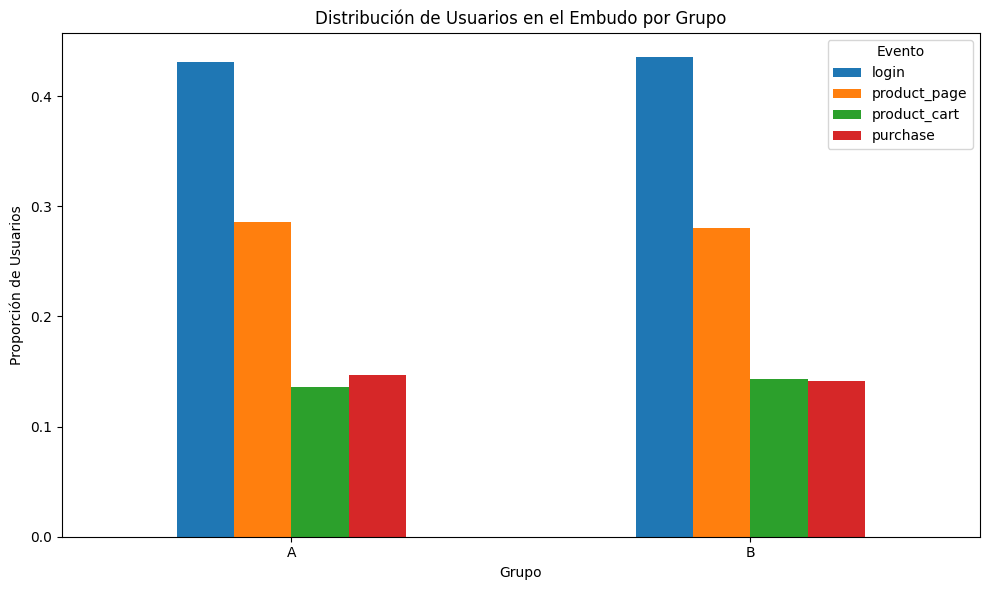

In [22]:
# Filtramos los eventos relevantes
embudo_eventos = ['login', 'product_page', 'product_cart', 'purchase']
events_filtered = events[events['event_name'].isin(embudo_eventos)]

# Unimos los eventos con los participantes para obtener los grupos
events_grouped = pd.merge(events_filtered, participants, on='user_id')

# Contamos los usuarios únicos por evento y grupo
event_counts = events_grouped.groupby(['group', 'event_name'])['user_id'].nunique().unstack(fill_value=0)

# Calculamos las conversiones de una etapa a otra dentro de cada grupo
conversiones_etapas = pd.DataFrame(index=event_counts.index)

# Calculamos la conversión de una etapa a otra (de login -> product_page, product_page -> product_cart, etc.)
for group in event_counts.index:
    # Conversión de login a product_page
    login_to_product_page = event_counts.loc[group, 'product_page'] / event_counts.loc[group, 'login'] if event_counts.loc[group, 'login'] > 0 else 0
    # Conversión de product_page a product_cart
    product_page_to_product_cart = event_counts.loc[group, 'product_cart'] / event_counts.loc[group, 'product_page'] if event_counts.loc[group, 'product_page'] > 0 else 0
    # Conversión de product_cart a purchase
    product_cart_to_purchase = event_counts.loc[group, 'purchase'] / event_counts.loc[group, 'product_cart'] if event_counts.loc[group, 'product_cart'] > 0 else 0

    # Guardamos las conversiones
    conversiones_etapas.loc[group, 'login_to_product_page'] = login_to_product_page
    conversiones_etapas.loc[group, 'product_page_to_product_cart'] = product_page_to_product_cart
    conversiones_etapas.loc[group, 'product_cart_to_purchase'] = product_cart_to_purchase

# Estudio de la distribución de usuarios por evento
event_distribution = event_counts.div(event_counts.sum(axis=1), axis=0)
event_distribution = event_distribution[['login', 'product_page', 'product_cart', 'purchase']]

# Visualizamos la distribución de usuarios en cada evento por grupo
plt.figure(figsize=(10, 6))
event_distribution.plot(kind='bar', stacked=False, ax=plt.gca())
plt.title('Distribución de Usuarios en el Embudo por Grupo')
plt.ylabel('Proporción de Usuarios')
plt.xlabel('Grupo')
plt.xticks(rotation=0)
plt.legend(title='Evento', loc='upper right', labels=['login', 'product_page', 'product_cart', 'purchase'])
plt.tight_layout()
plt.show()

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

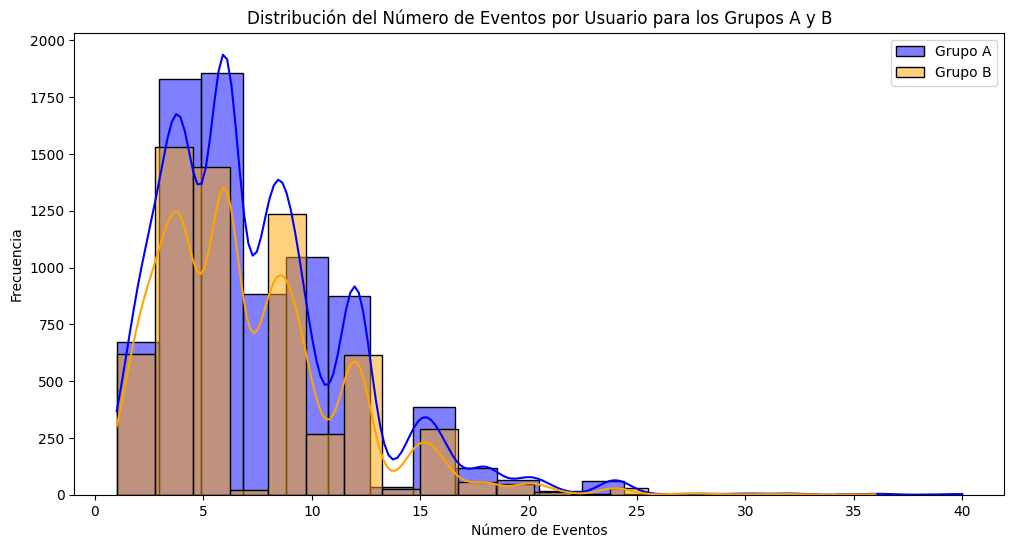

In [8]:
# Contamos el número de eventos por usuario en cada grupo
eventos_por_usuario_group = events_grouped.groupby(['user_id', 'group'])['event_name'].count().reset_index()

# Separar los grupos A y B
eventos_por_usuario_a = eventos_por_usuario_group[eventos_por_usuario_group['group'] == 'A']['event_name']
eventos_por_usuario_b = eventos_por_usuario_group[eventos_por_usuario_group['group'] == 'B']['event_name']

# Visualizamos la distribución de eventos por usuario
plt.figure(figsize=(12, 6))
sns.histplot(eventos_por_usuario_a, kde=True, color='blue', label='Grupo A', bins=20)
sns.histplot(eventos_por_usuario_b, kde=True, color='orange', label='Grupo B', bins=20)
plt.title('Distribución del Número de Eventos por Usuario para los Grupos A y B')
plt.xlabel('Número de Eventos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Del análisis podemos ver que el grupo "a" y el grupo "b" tiene relativamente el mismo número de eventos.

### ¿Hay usuarios que están presentes en ambas muestras?

In [9]:
# Obtenemos los usuarios de ambos grupos
grupo_a = participants[participants['group'] == 'A']['user_id']
grupo_b = participants[participants['group'] == 'B']['user_id']

# Intersección de usuarios en ambos grupos
usuarios_comunes = pd.merge(grupo_a, grupo_b, on='user_id')
print(f"Usuarios comunes entre los grupos: {usuarios_comunes.shape[0]}")

Usuarios comunes entre los grupos: 441


In [10]:
# Identificamos los usuarios que están en ambos grupos
usuarios_duplicados = pd.merge(grupo_a, grupo_b, on='user_id')

# Excluimos estos usuarios de la tabla de participantes
participants_sin_duplicados = participants[~participants['user_id'].isin(usuarios_duplicados['user_id'])]

# Verificamos cuántos usuarios han sido eliminados
print(f"Usuarios eliminados: {usuarios_duplicados.shape[0]}")

Usuarios eliminados: 441


### ¿Cómo se distribuye el número de eventos entre los días?

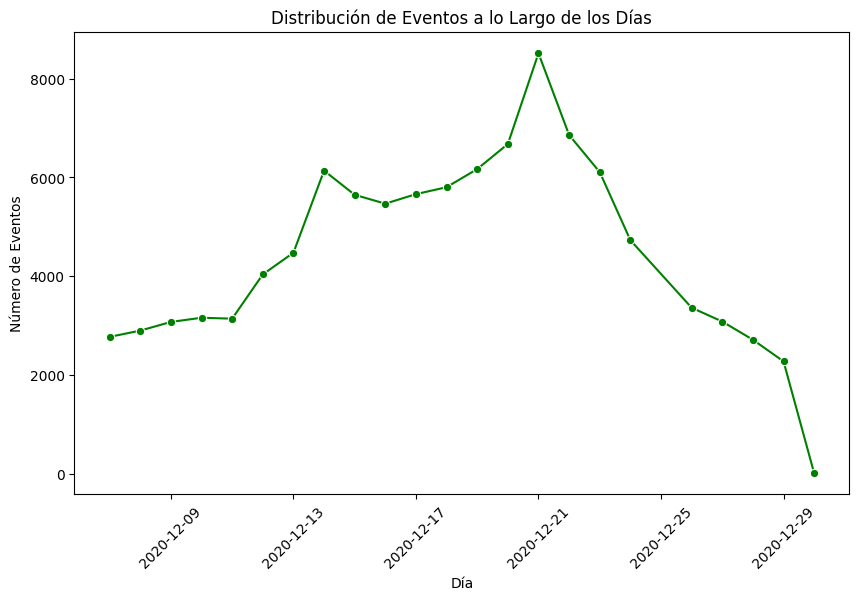

In [11]:
# Extraemos el día de los eventos
events_grouped['event_day'] = events_grouped['event_dt'].dt.date

# Contamos los eventos por día
eventos_por_dia = events_grouped.groupby('event_day')['user_id'].count()

# Visualizamos la distribución de eventos por día
plt.figure(figsize=(10, 6))
sns.lineplot(x=eventos_por_dia.index, y=eventos_por_dia.values, marker='o', color='green')
plt.title('Distribución de Eventos a lo Largo de los Días')
plt.xlabel('Día')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.show()

En general hubo más de 2,000 eventos en la mayoría de los grupos, lo que nos dice que tenemos muchos datos por ende los análisis y conclusiones serán muy acertados

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Del análisis podmeos ver que todo está correcto conforme al embudo, por lo que no hay pecularidades a considerar

## Prueba A/B

In [14]:
from statsmodels.stats.proportion import proportions_ztest

# Definir conversiones
conv_A = conversiones[(conversiones['group'] == 'A') & (conversiones['event_name'] == 'purchase')]['user_id'].sum()
conv_B = conversiones[(conversiones['group'] == 'B') & (conversiones['event_name'] == 'purchase')]['user_id'].sum()

# Definir tamaños de muestra
n_A = participants_sin_duplicados[participants_sin_duplicados['group'] == 'A'].shape[0]
n_B = participants_sin_duplicados[participants_sin_duplicados['group'] == 'B'].shape[0]

# Prueba Z para proporciones
stat, p_value = proportions_ztest([conv_A, conv_B], [n_A, n_B])

print(f"Z-score: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretación
if p_value < 0.05:
    print("Diferencia estadísticamente significativa entre los grupos.")
else:
    print("No hay diferencia significativa.")

Z-score: 0.3607
P-value: 0.7183
No hay diferencia significativa.


No hay diferencia estadísticamente significativa entre los grupos A (control) y B (nuevo embudo de pago) en cuanto a la cantidad de eventos por usuario.
Dado que el valor p es tan alto, no hay evidencia suficiente para concluir que el nuevo sistema de recomendaciones haya tenido un impacto en el número de eventos por usuario comparado con el grupo control.